In [1]:
import json
import numpy as np

import keras

C:\Users\sanat\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Importing keras libraries and packages

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

## Importing images for training

In [4]:
with open('D:/Projects/Tracking ship traffic with High-Resolution Satellite Images/shipsnet.json', 'r') as f:
    d = json.load(f)
    data, labels, locations, scene_ids = d['data'], d['labels'], d['locations'], d['scene_ids']

In [5]:
x = np.array(data).astype('uint8').reshape((-1, 3, 80, 80)) # 3 channels, 80x80 pixels
y = np.array(labels).astype('uint8')

### flip each x[i] from [layer][row][col] to [row][col][layer]

In [6]:
x = x.transpose([0,2,3,1])

### normalize pixel values to [0, 1]

In [7]:
x = x / 255

### turn y boolean values into categorical values (i.e. [p_notship, p_ship] vectors)

In [8]:
y = keras.utils.np_utils.to_categorical(y)

### expand training data by rotating and flipping

In [9]:
x_prime = np.concatenate((
    x,
    np.rot90(x, 1, (1,2)),
    np.rot90(x, 2, (1,2)),
    np.rot90(x, 3, (1,2)),
    np.flip(x, 1),
    np.flip(x, 1)
    ))

y_prime = np.concatenate((y, y, y, y, y, y))

## Convolution neural network

In [10]:
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

model = keras.models.Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(80, 80, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (9,9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (9,9), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

## Training the network

In [11]:
history = model.fit(x_prime, y_prime, epochs=12, validation_split=0.2, shuffle=True)

Train on 17280 samples, validate on 4320 samples
Epoch 1/12
17280/17280 [==============================] - 332s 19ms/step - loss: 0.3741 - acc: 0.8319 - val_loss: 0.2847 - val_acc: 0.8810
Epoch 2/12
17280/17280 [==============================] - 310s 18ms/step - loss: 0.2204 - acc: 0.9067 - val_loss: 0.2301 - val_acc: 0.9021
Epoch 3/12
17280/17280 [==============================] - 310s 18ms/step - loss: 0.1860 - acc: 0.9206 - val_loss: 0.2076 - val_acc: 0.9137
Epoch 4/12
17280/17280 [==============================] - 316s 18ms/step - loss: 0.1622 - acc: 0.9323 - val_loss: 0.1772 - val_acc: 0.9271
Epoch 5/12
17280/17280 [==============================] - 306s 18ms/step - loss: 0.1364 - acc: 0.9458 - val_loss: 0.1374 - val_acc: 0.9542
Epoch 6/12
17280/17280 [==============================] - 319s 18ms/step - loss: 0.1133 - acc: 0.9573 - val_loss: 0.1062 - val_acc: 0.9674
Epoch 7/12
17280/17280 [==============================] - 12690s 734ms/step - loss: 0.0950 - acc: 0.9653 - val_loss: 

## Visualizing model accuracy and loss

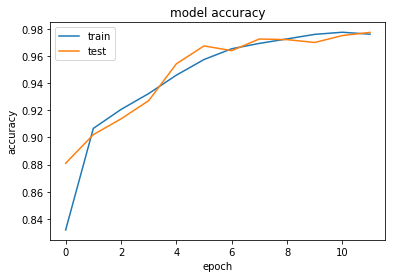

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

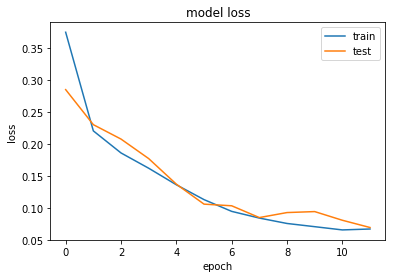

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Importing image to seach ships in

In [16]:
import PIL

scene = PIL.Image.open('D:/Projects/Tracking ship traffic with High-Resolution Satellite Images/sfbay_1.png')
tensor = np.array(scene).astype('uint8') / 255

In [17]:
width, height = scene.size
STEP_SIZE = 10

ships = {}

for row in range(0, height, STEP_SIZE):
    for col in range(0, width, STEP_SIZE):
        area = tensor[row:row+80, col:col+80, 0:3]
        
        if area.shape != (80, 80, 3):
            continue
            
        prediction = model.predict(np.array([area]))
        score = prediction[0][1]
        
        if score > 0.5:
            print("found ship at " + str([row,col]) + "with score " + str(score))
            ships[row, col] = score

found ship at [50, 1150]with score 0.50461936
found ship at [60, 1150]with score 0.51161987
found ship at [290, 1290]with score 0.53018945
found ship at [410, 1640]with score 0.86342037
found ship at [420, 1640]with score 0.97631615
found ship at [420, 1890]with score 0.9160956
found ship at [430, 1640]with score 0.7172844
found ship at [430, 1890]with score 0.9559842
found ship at [440, 1890]with score 0.66917056
found ship at [460, 2190]with score 0.8040353
found ship at [470, 2190]with score 0.9996132
found ship at [490, 1560]with score 0.9728318
found ship at [500, 1560]with score 0.6587025
found ship at [690, 950]with score 0.6713043
found ship at [750, 950]with score 0.5712747
found ship at [790, 1010]with score 0.7224776
found ship at [800, 1010]with score 0.89214003
found ship at [810, 1010]with score 0.8921218
found ship at [820, 1010]with score 0.8797231
found ship at [830, 1010]with score 0.6643311
found ship at [840, 2000]with score 0.67224544
found ship at [850, 2000]with 

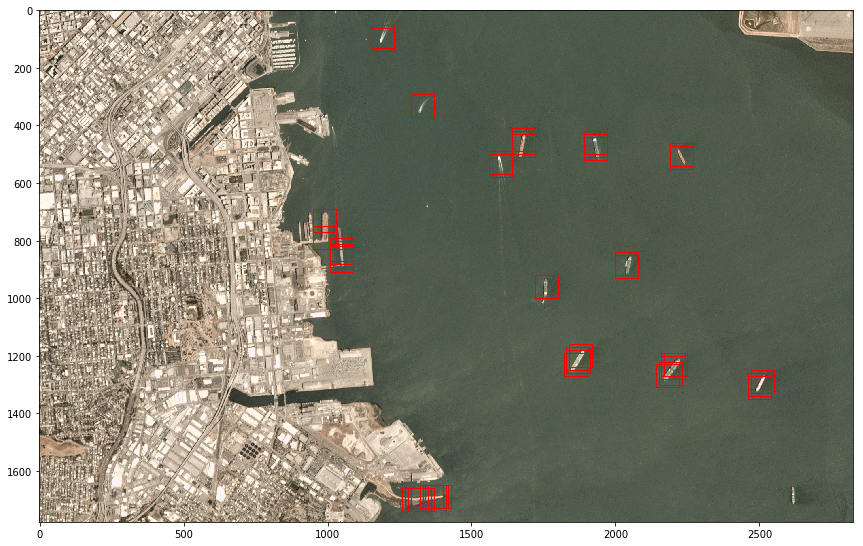

In [18]:
from matplotlib import pyplot as plt
from matplotlib import patches

fig = plt.figure(figsize=(16,32))
ax = fig.add_subplot(3, 1, 1)

ax.imshow(tensor)

for ship in ships:
    row, col = ship
    ax.add_patch(patches.Rectangle((col, row), 80, 80, edgecolor='r', facecolor='none'))

plt.show()